# **Cat&Dog Classification (from Kaggle) by CNN**

**1. Download the images and construct Dataset/DataLoader for Pytorch**

In [1]:
# Download the dataset from Kaggle using the below code.
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d tongpython/cat-and-dog
!ls
!unzip cat-and-dog.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  inflating: training

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import cv2, glob, numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
from glob import glob
class CatDog_DS(Dataset):
  def __init__(self,folder):
    dogs = glob(folder+'/dogs/*.jpg')
    cats = glob(folder+'/cats/*.jpg')
    self.fpaths = dogs+cats
    # Classify dog images as '1' and cat images as 0
    from random import shuffle, seed; seed(10)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]
  def __len__(self): return len(self.fpaths)
  def __getitem__(self,ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = cv2.imread(f)[:,:,::-1] # Here, "[:,:,::-1]"" flips the sequence of the original channels. As cv2 only takes BGR, the image channels need to be flipped.
    im = cv2.resize(im,(224,224))/255
    return torch.tensor(im).permute(2,0,1).to(device).float(), torch.tensor([target]).to(device).float()

trn_dir = '/content/training_set/training_set'
val_dir = '/content/test_set/test_set'

In [4]:
def get_data():
  train = CatDog_DS(trn_dir)
  trn_dl = DataLoader(train,batch_size=32,shuffle=True,drop_last=True)
  
  val = CatDog_DS(val_dir)
  val_dl = DataLoader(val,batch_size=32,shuffle=False,drop_last=True)
  return trn_dl, val_dl

trn_dl, val_dl = get_data()

In [17]:
print(len(CatDog_DS(trn_dir)))
print(len(CatDog_DS(val_dir)))

8005
2023


**2. Build necessary functions for training and evaluation**

In [5]:
from torch.nn.modules.pooling import MaxPool2d
def conv(ni,no,kernel_size,stride=1): # ni = number of in-channels, no = number of out-channels
  return nn.Sequential(
      nn.Conv2d(ni,no,kernel_size,stride),
      nn.BatchNorm2d(no),
      nn.MaxPool2d(2),
      nn.ReLU()
  )

def build_model():
  model = nn.Sequential(
      conv(3,64,3),
      conv(64,512,3),
      conv(512,512,3),
      conv(512,512,3),
      conv(512,512,3),
      conv(512,512,3),
      nn.Flatten(),
      nn.Linear(512,1),
      nn.Sigmoid() # Sigmoid for binary classification
  ).to(device)
  loss_fn = nn.BCELoss() # BCELoss for binary classification
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
  return model, loss_fn, optimizer

model, loss_fn, optimizer = build_model()

In [6]:
!pip install -q torch_summary
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─MaxPool2d: 2-3                    --
|    └─ReLU: 2-4                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-5                       295,424
|    └─BatchNorm2d: 2-6                  1,024
|    └─MaxPool2d: 2-7                    --
|    └─ReLU: 2-8                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-9                       2,359,808
|    └─BatchNorm2d: 2-10                 1,024
|    └─MaxPool2d: 2-11                   --
|    └─ReLU: 2-12                        --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      2,359,808
|    └─BatchNorm2d: 2-14                 1,024
|    └─MaxPool2d: 2-15                   --
|    └─ReLU: 2-16                        --
├─Sequential: 1-5                      

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─MaxPool2d: 2-3                    --
|    └─ReLU: 2-4                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-5                       295,424
|    └─BatchNorm2d: 2-6                  1,024
|    └─MaxPool2d: 2-7                    --
|    └─ReLU: 2-8                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-9                       2,359,808
|    └─BatchNorm2d: 2-10                 1,024
|    └─MaxPool2d: 2-11                   --
|    └─ReLU: 2-12                        --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      2,359,808
|    └─BatchNorm2d: 2-14                 1,024
|    └─MaxPool2d: 2-15                   --
|    └─ReLU: 2-16                        --
├─Sequential: 1-5                      

In [7]:
def train_batch(im,target,model,loss_fn,optimizer):
  model.train()
  optimizer.zero_grad()
  prediction = model(im)
  loss = loss_fn(prediction,target)
  loss.backward()
  optimizer.step()
  return loss.item()

@torch.no_grad()
def accuracy(im,target,model):
  model.eval()
  prediction = model(im)
  acc = (prediction > 0.5) == target
  return acc.cpu().numpy().tolist()

@torch.no_grad()
def validate_loss(im,target,model,loss_fn):
  model.eval()
  prediction = model(im)
  loss = loss_fn(prediction,target)
  return loss.item() 

**3. Train the model**

In [8]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(5):
  print(f'{epoch+1}/5 in progress')
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies = []
  for ix, batch in enumerate(iter(trn_dl)):
    im, target = batch
    trn_loss = train_batch(im,target,model,loss_fn,optimizer)
    train_epoch_losses.append(trn_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()

  for ix, batch in enumerate(iter(trn_dl)):
    im, target = batch
    trn_acc = accuracy(im,target,model)
    train_epoch_accuracies.extend(trn_acc)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    im, target = batch
    val_loss = validate_loss(im,target,model,loss_fn)
    val_acc = accuracy(im,target,model)
    val_epoch_accuracies.extend(val_acc)
  val_epoch_accuracy = np.mean(val_epoch_accuracies)
  
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(val_loss)
  val_accuracies.append(val_epoch_accuracy)

1/5 in progress
2/5 in progress
3/5 in progress
4/5 in progress
5/5 in progress


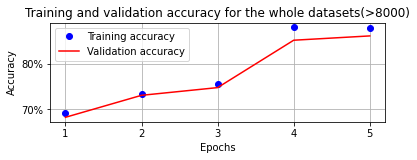

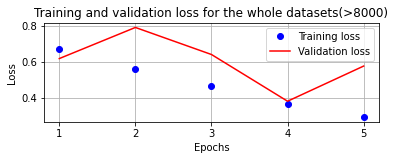

In [12]:
epochs = np.arange(5)+1
import matplotlib.ticker as mticker
%matplotlib inline

plt.subplot(211)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy for the whole datasets(>8000)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss for the whole datasets(>8000)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()